# Simulate differential mean expression data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.api as sm
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from statsmodels.stats.moment_helpers import cov2corr
import string

/tmp/ipykernel_2067744/644427709.py:12: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg')
import memento
import memento.simulate as simulate

In [5]:
data_path = '/data_volume/memento/simulation/'

In [5]:
def convert_params_nb(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def convert_params_binom(mu, v):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    p = 1-(v/mu)
    n = mu/p

    return np.ceil(n), np.p

### Extract parameters from HBEC dataset

In [238]:
ifn_adata = sc.read('/data_volume/memento/hbec/' + 'HBEC_type_I_filtered_counts_deep.h5ad')
q=0.07

In [241]:
X = ifn_adata[
    (ifn_adata.obs['stim'] == 'control') & \
    (ifn_adata.obs['cell_type'] == 'basal')].X.toarray()

m = X.mean(axis=0)
v = X.var(axis=0)

df = pd.DataFrame(
    zip(m,v),
    index=ifn_adata.var.index,
    columns=['m', 'v'])

m_filtered = m[m > 0.01]
v_filtered = v[m > 0.01]

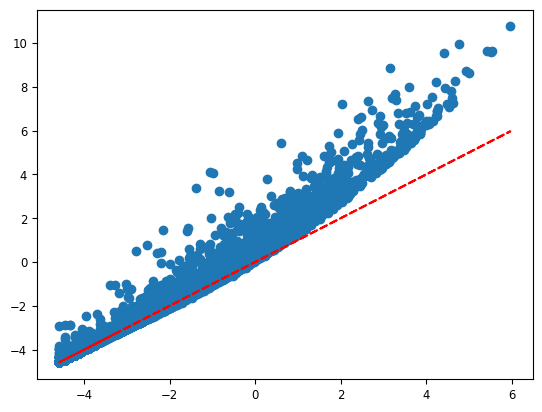

In [242]:
plt.scatter(
    np.log(m_filtered),
    np.log(v_filtered))
plt.plot(np.log(m_filtered), np.log(m_filtered), '--', color='red')

In [264]:
adata_1 = ifn_adata[(ifn_adata.obs['cell_type'] == 'ciliated') & (ifn_adata.obs['stim'] == 'control')]
adata_2 = ifn_adata[(ifn_adata.obs['cell_type'] == 'ciliated') & (ifn_adata.obs['stim'] == 'beta')]

x_param_1, z_param_1, Nc_1, good_idx_1 = simulate.extract_parameters(adata_1.X, q=q)
x_param_2, z_param_2, Nc_2, good_idx_2 = simulate.extract_parameters(adata_2.X, q=q)

In [19]:
import sys
sys.path.append('/home/ssm-user/Github/memento')

import memento.model.rna as rna
import memento.estimator.hypergeometric as hg
import memento.estimator.sample as samp

import memento.util as util

import logging
logging.basicConfig(
    format="%(asctime)s %(process)-7s %(levelname)-8s %(message)s",
    level=logging.INFO, 
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.captureWarnings(True)

In [6]:
adata = sc.read(data_path + 'de/anndata.h5ad')

adata.obs['q'] = 0.1
adata.X = adata.X.astype(float)

rna.MementoRNA.setup_anndata(
        adata=adata,
        q_column='q',
        label_columns=['group', 'condition'],
        num_bins=30,
        trim_percent=1,
        shrinkage=0.5)

adata = adata[:, adata.X.mean(axis=0).A1 > 0.01]
model = rna.MementoRNA(adata=adata)

model.compute_estimate(
    estimand='mean',
    get_se=True,
    n_jobs=30,
)

2023-07-20 20:48:09 2067744 INFO     setup_anndata: creating groups
2023-07-20 20:48:09 2067744 INFO     setup_anndata: computing cell sizes
2023-07-20 20:48:09 2067744 INFO     compute_estimate: running estimators for ['sum', 'mean', 'log_mean', 'log1p_mean', 'se_sum', 'se_mean', 'se_log_mean', 'se_log1p_mean', 'total_umi', 'cell_count']
2023-07-20 20:48:09 2067744 INFO     compute_estimate: gene_list is None, using all genes in AnnData object
2023-07-20 20:48:09 2067744 INFO     compute_estimate: getting estimates for memento_group^A^ctrl using 30 parallel jobs
2023-07-20 20:48:09 2067744 INFO     compute_estimate: getting estimates for memento_group^A^stim using 30 parallel jobs
2023-07-20 20:48:09 2067744 INFO     compute_estimate: getting estimates for memento_group^B^ctrl using 30 parallel jobs
2023-07-20 20:48:09 2067744 INFO     compute_estimate: getting estimates for memento_group^B^stim using 30 parallel jobs


In [8]:
count_multiplier = model.estimates['total_umi'].values/model.adata.uns['memento']['umi_depth']
sampling_variance =  (model.estimates['se_mean']**2)*count_multiplier**2

In [18]:
model.estimates['mean']['gene_24']

memento_group^A^ctrl    0.005147
memento_group^A^stim    0.025671
memento_group^B^ctrl    0.020607
memento_group^B^stim    0.019237
Name: gene_24, dtype: float64

In [28]:
group = 'memento_group^A^ctrl'
barcodes = model.adata.uns['memento']['group_barcodes'][group]

data = model.subset_matrix(barcodes, ['gene_24']).tocsc() #CSC format is faster
sf = model.adata.obs.loc[barcodes]['memento_size_factor'].values
approx_sf = model.adata.obs.loc[barcodes]['memento_approx_size_factor'].values
q = model.adata.uns['memento']['group_q'][group]

In [ ]:
model

In [14]:
sampling_variance['gene_24']

memento_group^A^ctrl    0.000000
memento_group^A^stim    9.694920
memento_group^B^ctrl    1.471632
memento_group^B^stim    7.015041
Name: gene_24, dtype: float64

### Simulate data

In [271]:
np.where(means > variances)

(array([0, 0, 0, ..., 3, 3, 3]),
 array([    1,    13,    23, ..., 21122, 21123, 21125]))

In [269]:
base_mean = z_param_1[0]
num_genes = base_mean.shape[0]
treatment_effect = np.zeros(num_genes)
treatment_effect[:100] = 0.3

means = np.zeros((4, num_genes))
means[0] = base_mean
means[1] = base_mean+treatment_effect
means[2] = base_mean + (0.2)
means[3] = base_mean + (0.2) + treatment_effect + (1)

# For Binom
variances = np.zeros((4, num_genes))
variances[0] = z_param_1[1]
variances[1] = z_param_1[1]
variances[2] = z_param_1[1]
variances[3] = z_param_1[1]

In [276]:
convert_params_binom(means, binom_variances)

NameError: name 'binom_variances' is not defined

In [282]:
def simulate_counts(means, variances, num_cell_per_group):
    
    num_groups, num_genes = means.shape
    
    counts = np.zeros((num_cells_per_group, num_groups, num_genes))
    
    binom_idxs = np.where(means >= variances)
    nb_idxs = np.where(means < variances)
    
    binom_variances = variances
    binom_variances[binom_variances > means] = means[binom_variances > means]-1e-3
    nb_dispersions = (variances-means)/means**2
    nb_dispersions[nb_dispersions < 0] = 1e-3
    
    return convert_params_binom(means, binom_variances)
    binom_counts = stats.binom.rvs(
        *convert_params_binom(means, binom_variances), 
        size=(num_cells_per_group, num_groups, num_genes))
    nb_counts = stats.nbinom.rvs(
        *convert_params_nb(means, 1/nb_dispersions), 
        size=(num_cells_per_group, num_groups, num_genes))

    counts[:, binom_idxs[0], binom_idxs[1]] = binom_counts
    counts[:, nb_idxs[0], nb_idxs[1]] = nb_counts

    return counts.reshape(-1, num_genes)

In [284]:
n, p=simulate_counts(means, variances, 100)

In [290]:
p.max()

1.6959756848099379

In [262]:
base_mean = z_param_1[0]
num_genes = base_mean.shape[0]
treatment_effect = np.zeros(num_genes)
treatment_effect[:100] = 0.3

means = np.zeros((4, num_genes))
means[0] = base_mean
means[1] = base_mean+treatment_effect
means[2] = base_mean + (0.2)
means[3] = base_mean + (0.2) + treatment_effect + (1)

# For Binom
variances = np.zeros((4, num_genes))
variances[0] = z_param_1[1]
variances[1] = z_param_2[1]
variances[2] = z_param_1[1]
variances[3] = z_param_2[1]

# For NB
dispersions = np.zeros((4, num_genes))
dispersions[0] = 0.1
dispersions[1] = 5
dispersions[2] = 0.1
dispersions[3] = 5

num_cells_per_group = 50
design = pd.DataFrame(
    [
        ('ctrl', 'A'),
        ('stim', 'A'),
        ('ctrl', 'B'),
        ('stim', 'B')], columns=['condition', 'group'])
design = pd.concat([design for i in range(num_cells_per_group)])
     

counts = stats.nbinom.rvs(
    *convert_params_nb(means, 1/dispersions), 
    size=(num_cells_per_group, 4, num_genes)).reshape(-1, num_genes)
# counts = stats.binom.rvs(
#     *convert_params_binom(means, variances), 
#     size=(num_cells_per_group, 4, num_genes)).reshape(-1, num_genes)
_, hyper_captured = simulate.capture_sampling(counts, q=q, process='hyper')
# hyper_captured = counts

trial = 0
expr_df = pd.DataFrame(counts)
grouped = pd.concat([design.reset_index(drop=True), expr_df], axis=1)
pseudobulks = grouped.groupby(['group', 'condition']).sum()
pseudobulks.index = [x+'-'+y for x, y in itertools.product(design['group'].unique(), design['condition'].unique())]

# anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
# # anndata.var['is_null'] = null_de_genes
# anndata.obs = design.copy()

# anndata.write(data_path + 'means/anndata_{}.h5ad'.format(trial))
pseudobulks.T.to_csv(data_path + 'means/pseudobulks_{}.csv'.format(trial))

In [209]:
X1 = np.array([
    [1, 0, -0.5, 0],
    [1, 1, -0.5, -0.5],
    [1, 0, 0.5, 0],
    [1, 1, 0.5, 0.5]
])

X2 = np.array([
    [1, 0, 0],
    [1, 1, 0,],
    [1, 0, 1,],
    [1, 1, 1,]
])

X3 = np.array([
    [1, 0,],
    [1, 1,],
    [1, 0,],
    [1, 1,]
])

pv = np.zeros(1000)
for trial in range(1000):
    beta = np.array([5, 0, 2, 1]).reshape(-1,1)
    y = stats.poisson.rvs(np.exp(X1@beta))
    fit = sm.Poisson(y,X1).fit(disp=0)
    pv[trial] = fit.pvalues[1]
    

In [210]:
np.exp(X1@beta)

array([[ 54.59815003],
       [ 33.11545196],
       [403.42879349],
       [665.14163304]])

(array([104., 103., 110.,  94., 109., 101.,  93.,  95., 111.,  80.]),
 array([6.62217359e-04, 1.00066950e-01, 1.99471682e-01, 2.98876415e-01,
        3.98281147e-01, 4.97685880e-01, 5.97090612e-01, 6.96495345e-01,
        7.95900077e-01, 8.95304810e-01, 9.94709542e-01]),
 <BarContainer object of 10 artists>)

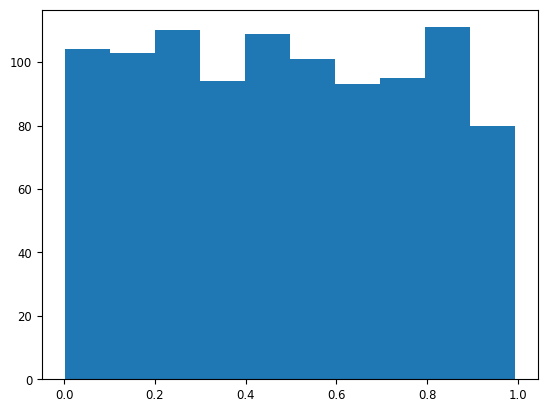

In [211]:
plt.hist(pv)

edger_lrt - fpr: 0.018920617189136353 - tpr : 0.46080760095011875 - thresh : 0.05
edger_qlft - fpr: 0.027508203588633665 - tpr : 0.45605700712589076 - thresh : 0.05
memento - fpr: 0.04740626963624939 - tpr : 0.6033254156769596 - thresh : 0.05
t - fpr: 0.04635900300216435 - tpr : 0.49406175771971494 - thresh : 0.05


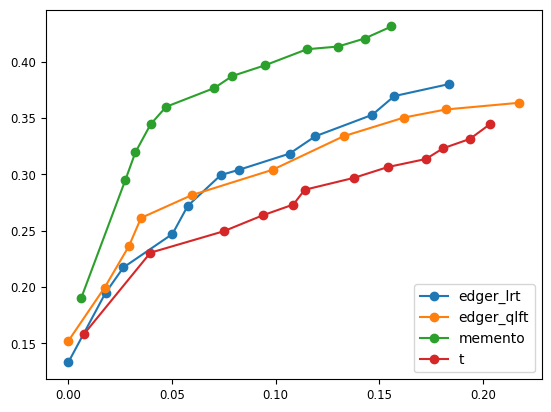

In [256]:
# Read anndata object and setup results
adata = sc.read(data_path + 'de/anndata.h5ad')

# Set up results holder
results = {}

# Read edger
results['edger_lrt'] = pd.read_csv(data_path + 'de/edger_lrt.csv', index_col=0)[['logFC', 'PValue', 'FDR']]
results['edger_qlft'] = pd.read_csv(data_path + 'de/edger_qlft.csv', index_col=0)[['logFC', 'PValue', 'FDR']]

# Read memento
results['memento'] = pd.read_csv(data_path + 'de/memento.csv', index_col=0)[['coef', 'pval', 'fdr']]

# Read t test
results['t'] = pd.read_csv(data_path + 'de/t.csv', index_col=0)[['coef', 'pval', 'fdr']]

# Get overlapping genes
genes = set(adata.var.index)
for method, result in results.items():
    results[method] = result.join(adata.var,how='inner')
    genes &= set(result.index)
genes = list(genes)
for method, result in results.items():
    results[method] = result.loc[genes]
    results[method].columns = ['coef', 'pval', 'fdr', 'is_de']

# Print some statistics
n=12
thresholds = {
    'memento':np.linspace(0.001, 0.2, n),
    't':np.linspace(0.001, 0.2, n),
    'edger_lrt':np.linspace(0.01, 0.7, n),
    'edger_qlft':np.linspace(0.01, 0.6, n-2)       
}
check_thresh = 0.05
plt.figure()
for method, result in results.items():

    tpr = (result.query('is_de')['pval'] < check_thresh).mean()
    fpr = (result.query('~is_de')['pval'] < check_thresh).mean()
    print(f'{method} - fpr: {fpr} - tpr : {tpr} - thresh : {check_thresh}')

    fdr = []
    tpr = []
    sorted_result = result.sort_values('fdr')
    for thresh in thresholds[method]:

        hits = result.query(f'fdr < {thresh}')
        fdr.append(1-hits['is_de'].mean())
        tpr.append(hits['is_de'].sum()/result['is_de'].sum())
    plt.plot(fdr, tpr, '-o', label=method)
plt.legend()